In [ ]:
# installing Pyspark
!pip install pyspark

In [ ]:
# ingnoring the warning signs
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# importing pyspark functions and libraries
from pyspark.sql.functions import sum, col, desc, mean, when
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Assessment').getOrCreate()

In [ ]:
# importing data manipulation and visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

In [ ]:
# importing machine libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [ ]:
from google.colab import files
files.upload()

Loading the facts table

In [ ]:
# reading the datasets
df_fact = spark.read.csv('FactInternetSales.csv', header=True, inferSchema=True)
df_currency = spark.read.csv('DimCurrency.csv', header=True, inferSchema=True)
df_product = spark.read.csv('DimProduct.csv', header=True, inferSchema=True)
df_customer = spark.read.csv('DimCustomer.csv', header=True, inferSchema=True)
df_Territory = spark.read.csv('DimSalesTerritory.csv', header=True, inferSchema=True)
df_Date = spark.read.csv('DimDate.csv', header=True, inferSchema=True)

In [ ]:
# Creating new columns TotalSpent and Profit
df_fact = df_fact.withColumn("Profit", df_fact.UnitPrice - df_fact.TotalProductCost)
df_fact = df_fact.withColumn("TotalSpent", df_fact.UnitPrice + df_fact.TaxAmt + df_fact.Freight)
# creating a new column to segment the customers in good(1) and bad(0)
df_fact = df_fact.withColumn('customerSeg', when(col('TotalSpent') < 537.1, 0).otherwise(1))

In [ ]:
# showing the datasets
df_fact.show(2)
df_currency.show(2)
df_product.show(2)
df_customer.show(2)
df_Territory.show(2)
df_Date.show(2)

+----------+------------+----------+-----------+-----------+------------+-----------+-----------------+----------------+--------------------+--------------+-------------+---------+--------------+--------------------+--------------+-------------------+----------------+-----------+--------+-------+---------------------+----------------+-------------------+-------------------+-------------------+------------------+------------------+-----------+
|ProductKey|OrderDateKey|DueDateKey|ShipDateKey|CustomerKey|PromotionKey|CurrencyKey|SalesTerritoryKey|SalesOrderNumber|SalesOrderLineNumber|RevisionNumber|OrderQuantity|UnitPrice|ExtendedAmount|UnitPriceDiscountPct|DiscountAmount|ProductStandardCost|TotalProductCost|SalesAmount|  TaxAmt|Freight|CarrierTrackingNumber|CustomerPONumber|          OrderDate|            DueDate|           ShipDate|            Profit|        TotalSpent|customerSeg|
+----------+------------+----------+-----------+-----------+------------+-----------+-----------------+---

In [ ]:
df_fact.summary().show()

+-------+------------------+-------------------+-------------------+--------------------+------------------+------------------+-----------------+------------------+----------------+--------------------+--------------+-------------+-----------------+-----------------+--------------------+--------------+-------------------+-----------------+-----------------+------------------+------------------+---------------------+----------------+------------------+------------------+-------------------+
|summary|        ProductKey|       OrderDateKey|         DueDateKey|         ShipDateKey|       CustomerKey|      PromotionKey|      CurrencyKey| SalesTerritoryKey|SalesOrderNumber|SalesOrderLineNumber|RevisionNumber|OrderQuantity|        UnitPrice|   ExtendedAmount|UnitPriceDiscountPct|DiscountAmount|ProductStandardCost| TotalProductCost|      SalesAmount|            TaxAmt|           Freight|CarrierTrackingNumber|CustomerPONumber|            Profit|        TotalSpent|        customerSeg|
+-------+-

# The Exploratory Data Analysis

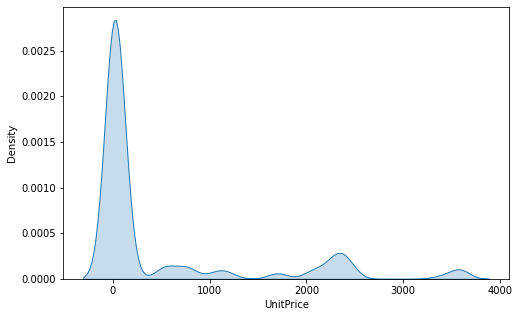

In [ ]:
# KDE plot od the Unit price column
kde_price = df_fact.select("UnitPrice")
plt.figure(figsize=(8,5))
kde_price = kde_price.toPandas()
sns.kdeplot(kde_price['UnitPrice'], shade = True)
plt.show()

Above is the Kernel Density Distribution plot of the Unit Price column, it appears that the distribution is highly left-skewed. In order words, it indicates that we have majority of the price around 100 per unit

<Figure size 360x720 with 0 Axes>

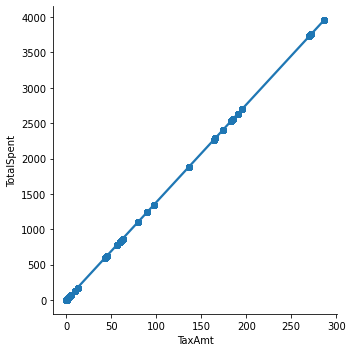

In [ ]:
#scatter plot
TA = df_fact.select('TotalSpent', 'TaxAmt').toPandas()
plt.figure(figsize=(5,10))
sns.lmplot(x='TaxAmt', y='TotalSpent', data=TA);

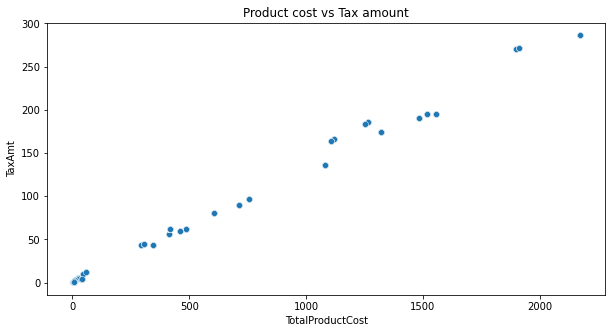

In [ ]:
#scatter plot
yt = df_fact.select('TotalProductCost', 'TaxAmt').toPandas()
plt.figure(figsize=(10,5))
sns.scatterplot(x='TotalProductCost', y='TaxAmt', data=yt, palette = 'winter')
plt.title('Product cost vs Tax amount');

In [ ]:
# joining the fact and territory table together
fact_terr = df_fact.join(df_Territory, on = ['SalesTerritoryKey'], how = 'left_outer')
fact_terr.show(2)

+-----------------+----------+------------+----------+-----------+-----------+------------+-----------+----------------+--------------------+--------------+-------------+---------+--------------+--------------------+--------------+-------------------+----------------+-----------+--------+-------+---------------------+----------------+-------------------+-------------------+-------------------+------------------+------------------+-----------+--------------------------+--------------------+---------------------+-------------------+--------------------+
|SalesTerritoryKey|ProductKey|OrderDateKey|DueDateKey|ShipDateKey|CustomerKey|PromotionKey|CurrencyKey|SalesOrderNumber|SalesOrderLineNumber|RevisionNumber|OrderQuantity|UnitPrice|ExtendedAmount|UnitPriceDiscountPct|DiscountAmount|ProductStandardCost|TotalProductCost|SalesAmount|  TaxAmt|Freight|CarrierTrackingNumber|CustomerPONumber|          OrderDate|            DueDate|           ShipDate|            Profit|        TotalSpent|customer

+---------------------+------------------+
|SalesTerritoryCountry|       avg(Profit)|
+---------------------+------------------+
|              Germany|211.08813600000246|
|               France|195.44165559554006|
|        United States|182.76709158077773|
|               Canada|108.91358283464798|
|            Australia|276.19745794680404|
|       United Kingdom| 201.3453197219836|
+---------------------+------------------+



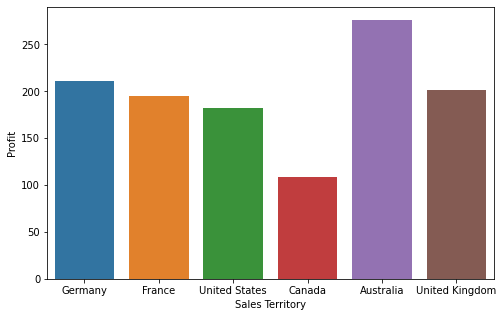

In [ ]:
# Profit made on sales in each Territory Countey
fact_terr.groupby('SalesTerritoryCountry').agg({'Profit' : 'mean'}).show()
pro = fact_terr.groupby('SalesTerritoryCountry').agg({'Profit' : 'mean'}).toPandas()
plt.figure(figsize=(8,5))
sns.barplot( x = pro['SalesTerritoryCountry'], y = pro['avg(Profit)'])
plt.xlabel('Sales Territory')
plt.ylabel('Profit');

In [ ]:
fact_terr.groupBy("SalesTerritoryGroup").agg(mean("UnitPrice").alias("Mean UnitPrice")).sort(desc("Mean UnitPrice")).show(truncate = False)

+-------------------+------------------+
|SalesTerritoryGroup|Mean UnitPrice    |
+-------------------+------------------+
|Pacific            |678.9809355115221 |
|Europe             |493.67252271557425|
|North America      |392.47460201987155|
+-------------------+------------------+



In [ ]:
# joining the fact and currency table
fact_curr = df_fact.join(df_currency, on = ['CurrencyKey'], how = 'left_outer')
fact_curr.show(2)

+-----------+----------+------------+----------+-----------+-----------+------------+-----------------+----------------+--------------------+--------------+-------------+---------+--------------+--------------------+--------------+-------------------+----------------+-----------+--------+-------+---------------------+----------------+-------------------+-------------------+-------------------+------------------+------------------+-----------+--------------------+---------------+
|CurrencyKey|ProductKey|OrderDateKey|DueDateKey|ShipDateKey|CustomerKey|PromotionKey|SalesTerritoryKey|SalesOrderNumber|SalesOrderLineNumber|RevisionNumber|OrderQuantity|UnitPrice|ExtendedAmount|UnitPriceDiscountPct|DiscountAmount|ProductStandardCost|TotalProductCost|SalesAmount|  TaxAmt|Freight|CarrierTrackingNumber|CustomerPONumber|          OrderDate|            DueDate|           ShipDate|            Profit|        TotalSpent|customerSeg|CurrencyAlternateKey|   CurrencyName|
+-----------+----------+--------

In [ ]:
fact_curr.describe().show()

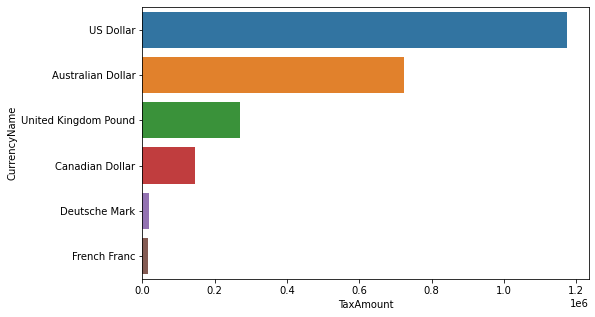

In [ ]:
bar_tax = fact_curr.groupBy("CurrencyName").agg(sum("TaxAmt").alias("TaxAmount")).sort(desc("TaxAmount")).toPandas()
plt.figure(figsize=(8,5))
sns.barplot(data=bar_tax, x="TaxAmount", y="CurrencyName")

In [ ]:
# Joining the fact and customer table
fact_cus = df_fact.join(df_customer, on = ['customerKey'], how = 'left_outer')
fact_cus.show(2)

+-----------+----------+------------+----------+-----------+------------+-----------+-----------------+----------------+--------------------+--------------+-------------+---------+--------------+--------------------+--------------+-------------------+----------------+-----------+--------+-------+---------------------+----------------+-------------------+-------------------+-------------------+------------------+------------------+-----------+------------+--------------------+-----+---------+----------+--------+---------+-------------------+-------------+------+------+--------------------+------------+-------------+--------------------+----------------+--------------------+---------------+-----------------+-----------------+----------------+--------------+---------------+------------------+------------+-------------------+-------------------+---------------+
|CustomerKey|ProductKey|OrderDateKey|DueDateKey|ShipDateKey|PromotionKey|CurrencyKey|SalesTerritoryKey|SalesOrderNumber|SalesOrder

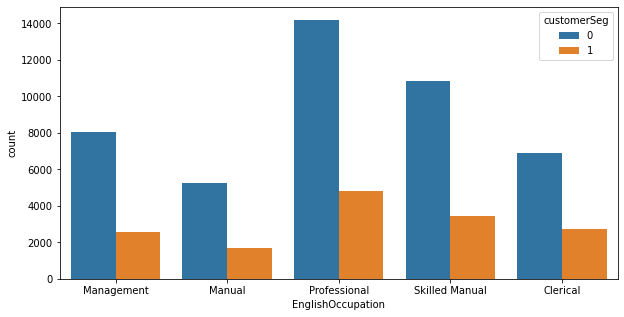

In [ ]:
# coutplot of occupation of good and bad customer
cus_seg = fact_cus.toPandas()
plt.figure(figsize=(10,5))
sns.countplot(x ='EnglishOccupation', hue='customerSeg', data= cus_seg)

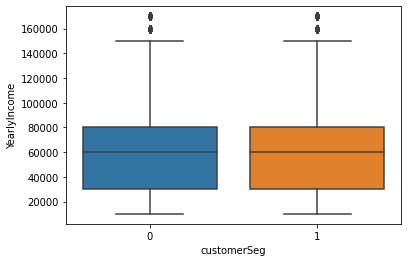

In [ ]:
# Boxplot of customer segment spending rate speding rate
sns.boxplot(x='customerSeg', y='YearlyIncome', data= cus_seg);

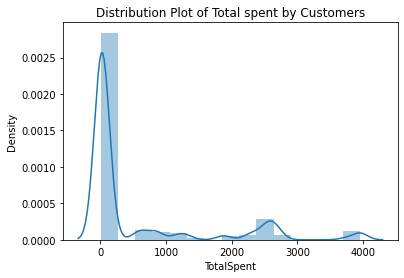

In [ ]:
yt = fact_cus.select('YearlyIncome', 'TotalSpent').toPandas()
sns.distplot(yt['TotalSpent'], kde=True, bins=15)
plt.title('Distribution Plot of Total spent by Customers');

As seen from the frequency distribution plot above, majority of the customers spent a total amount below 500, which means majority of the customers spend minimally in relation to their earnings

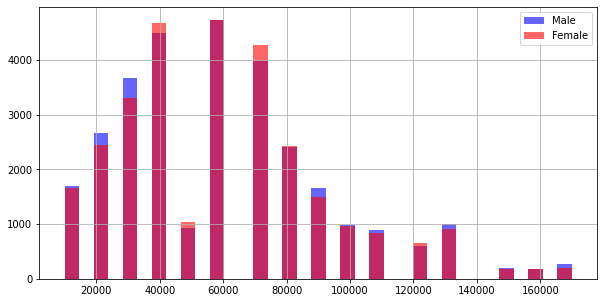

In [ ]:
sex = fact_cus.select('Gender', 'YearlyIncome').toPandas()
plt.figure(figsize=(10,5))
sex[sex['Gender'] == 'M']['YearlyIncome'].hist(bins=35, color='blue', alpha= 0.6, label ='Male' )
sex[sex['Gender'] == 'F']['YearlyIncome'].hist(bins=35, color='red', alpha= 0.6, label ='Female')
#plt.title('Yearly Income')
plt.legend();

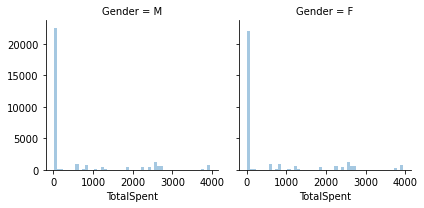

In [ ]:
#Facet Gridplot showing the spending rate of both genders
fc = fact_cus.toPandas()
g = sns.FacetGrid(data=fc, col='Gender')
g.map(sns.distplot, 'TotalSpent', kde=False);

As evident above, the spending rate of house owners is much higher that that of non-house owners, this might have come off from the fact that they have enough financial power to spend more on basic resources.

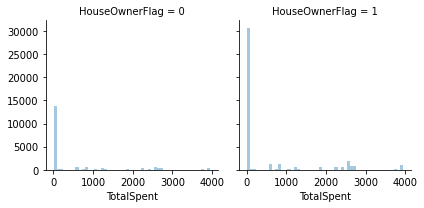

In [ ]:
#Facet Gridplot showing the spending rate of house ownership
fc = fact_cus.toPandas()
g = sns.FacetGrid(data=fc, col='HouseOwnerFlag')
g.map(sns.distplot, 'TotalSpent', kde=False);

Similar to the house owners comparison, the above chart comapres spending rate of both sex, but in this case, there is no significant difference in both genders, i.e, they both spend on similar rate.

In [ ]:
fact_cus.corr('TotalProductCost', 'TaxAmt')

0.9978454558160699

In [ ]:
#Contingency table of customers with English education and their gender 
fact_cus.crosstab("EnglishEducation", "Gender").show()

+-----------------------+----+----+
|EnglishEducation_Gender|   F|   M|
+-----------------------+----+----+
|        Partial College|8318|8305|
|        Graduate Degree|5400|5203|
|            High School|5040|5280|
|              Bachelors|8993|9151|
|    Partial High School|2266|2442|
+-----------------------+----+----+



Above is the contingency(cross) tabulation of customers with English education and their respective sex.

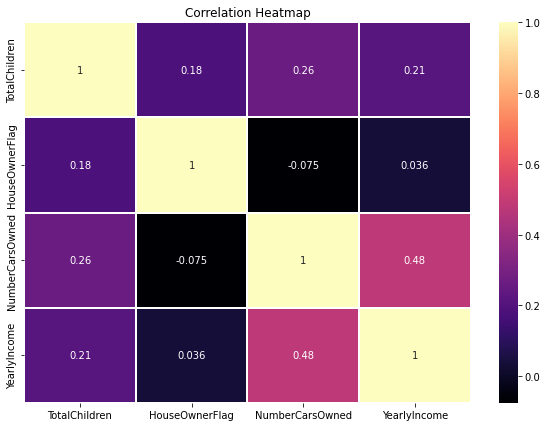

In [ ]:
corre = fact_cus.select('TotalChildren', 'HouseOwnerFlag', 'NumberCarsOwned', 'YearlyIncome').toPandas().corr()
plt.figure(figsize=(10,7))
sns.heatmap(corre, cmap = 'magma', linewidths=1, linecolor='white', annot = True)
plt.title('Correlation Heatmap');

# CLASSIFICATION

In [ ]:
# Joining the tables for Classification Analysis
df_join1 = fact_terr.join(df_customer, on = ['CustomerKey'], how = 'left_outer')
df_class = df_join1.join(df_product, on = ['ProductKey'], how = 'left_outer')

In [ ]:
# Selecting the needed features
classs = df_class.select('SalesTerritoryGroup', 'BirthDate', 'YearlyIncome', 'TotalChildren', 'NumberChildrenAtHome', 'EnglishEducation', 'EnglishOccupation', 'NumberCarsOwned', 'customerSeg').toPandas()
classs.head()

,SalesTerritoryGroup,BirthDate,YearlyIncome,TotalChildren,NumberChildrenAtHome,EnglishEducation,EnglishOccupation,NumberCarsOwned,customerSeg
0,North America,1952-02-19,70000.0,5,0,Bachelors,Management,3,1
1,Europe,1970-06-17,20000.0,3,3,High School,Manual,0,1
2,North America,1952-06-01,40000.0,5,0,High School,Professional,3,1
3,North America,1943-11-10,80000.0,4,0,Graduate Degree,Management,2,1
4,Pacific,1973-08-14,70000.0,0,0,Bachelors,Professional,1,1


DATA MANIPULATION

In [ ]:
# converting the customer date of birth to age
from datetime import date
classs['BirthDate'] = pd.to_datetime(classs.BirthDate)
classs['Customer_Age'] = 2023 - classs['BirthDate'].apply(lambda time: time.year)

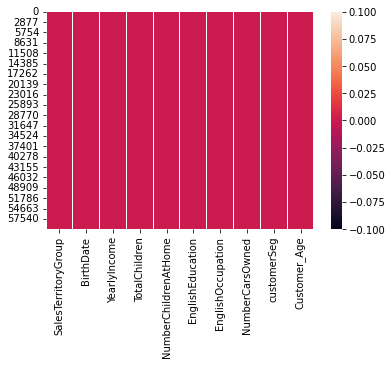

In [ ]:
# using seaborn to create a heatmap to visualise missing values
sns.heatmap(classs.isnull());

The all-rhymed heatmap above inidicates nonNA dataset, so its safe to further with the analysis

In [ ]:
# encoding the string variables
STG = pd.get_dummies(classs['SalesTerritoryGroup'], drop_first=True)
edu = pd.get_dummies(classs['EnglishEducation'], drop_first=True)
occu = pd.get_dummies(classs['EnglishOccupation'], drop_first=True)

In [ ]:
# concatenating the new variables to the main and dropping the old ones.
classs = pd.concat([classs, STG, edu, occu], axis = 1)
classs.drop(columns=['SalesTerritoryGroup', 'EnglishEducation', 'EnglishOccupation', 'BirthDate'], inplace = True)

In [ ]:
classs = classs[['YearlyIncome',	'TotalChildren',	'NumberChildrenAtHome',	'NumberCarsOwned',	'customerSeg',	'Customer_Age',	'North America',	'Pacific',	'High School',	'Partial High School',	'Management',	'Skilled Manual']]
classs.head(2)

,YearlyIncome,TotalChildren,NumberChildrenAtHome,NumberCarsOwned,customerSeg,Customer_Age,North America,Pacific,High School,Partial High School,Management,Skilled Manual
0,70000.0,5,0,3,1,71,1,0,0,0,1,0
1,20000.0,3,3,0,1,53,0,0,1,0,0,0


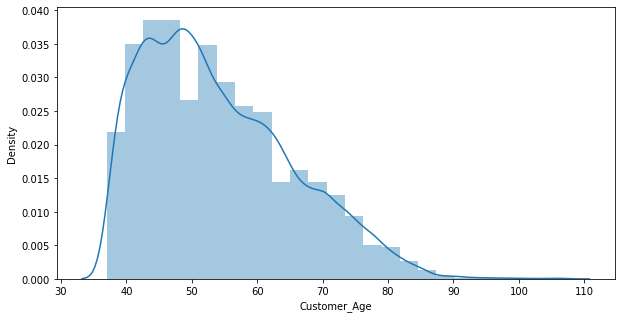

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(classs['Customer_Age'], kde=True, bins= 25);

# DATA PREPROCESSING

In [ ]:
# creating the independent and dependent variables
X = classs.drop(['customerSeg'], axis = 1)
y = classs['customerSeg']

In [ ]:
# Splitting the dataset into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=101)

In [ ]:
# scaling out the dataset
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.fit_transform(X_test)

# LOGISTIC REGRESSION

In [ ]:
#creating a logistic regression object
logmodel = LogisticRegression()

In [ ]:
logmodel.fit(X_train,y_train)

LogisticRegression()

In [ ]:
log_pred = logmodel.predict(X_test)

In [ ]:
#confusion matrix
print(confusion_matrix(y_test, log_pred))
print('\n')
print(classification_report(y_test, log_pred))

[[6710   47]
 [2254   49]]


              precision    recall  f1-score   support

           0       0.75      0.99      0.85      6757
           1       0.51      0.02      0.04      2303

    accuracy                           0.75      9060
   macro avg       0.63      0.51      0.45      9060
weighted avg       0.69      0.75      0.65      9060



# SUPPORT VECTOR MACHINE

In [ ]:
classifier = SVC(kernel='rbf', random_state =0)
classifier.fit(X_train, y_train)

SVC(random_state=0)

In [ ]:
svc_pred = classifier.predict(X_test)

In [ ]:
print(confusion_matrix(y_test, svc_pred))
print('\n')
print(classification_report(y_test, svc_pred))

[[6720   37]
 [2270   33]]


              precision    recall  f1-score   support

           0       0.75      0.99      0.85      6757
           1       0.47      0.01      0.03      2303

    accuracy                           0.75      9060
   macro avg       0.61      0.50      0.44      9060
weighted avg       0.68      0.75      0.64      9060



# NAIV BAYES

In [ ]:
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

In [ ]:
nb_pred = classifier.predict(X_test)

In [ ]:
print(confusion_matrix(y_test, nb_pred))
print('\n')
print(classification_report(y_test, nb_pred))

[[10166  1132]
 [ 3102   700]]


              precision    recall  f1-score   support

           0       0.77      0.90      0.83     11298
           1       0.38      0.18      0.25      3802

    accuracy                           0.72     15100
   macro avg       0.57      0.54      0.54     15100
weighted avg       0.67      0.72      0.68     15100



NOTE: all libraries used are uploaded in the earlier part of this book